## Table of contents

[**Section I**](#Section-I:-Preprocessing-data-files): Preprocessing data files

[**Section II**](#Section-II:-Feature-Engineering-and-Text-Preprocessing): Feature Engineering and Text Preprocessing

[**Section III**](#Section-III:-Modelling): Modelling

In [2]:
# from collections import Counter
# from datetime import datetime
# import json
# import jsonpickle
import os
import pickle
import re
import sys
# import time

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
# import nltk
# from nltk import FreqDist, word_tokenize
# from nltk.collocations import *
# from nltk.corpus import stopwords
# from nltk.corpus import wordnet
# from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
# import preprocessor as p
# import seaborn as sns
# from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# # from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
# from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier

In [3]:
%load_ext autoreload
%autoreload 1

sys.path.append("../../src/")

# from d01_data.data_processing import *
# from d02_features.text_preprocessing import *
from d03_models.modelling_functions import *
from d04_visualisation.building_charts import *

# %aimport d01_data.data_processing
# %aimport d02_features.text_preprocessing
%aimport d03_models.modelling_functions
%aimport d04_visualisation.building_charts

AttributeError: module 'numpy.polynomial' has no attribute 'polynomial'

## Section I: Preprocessing data files

### Dataset #1: Russian troll tweets

Process raw Russian tweets data into `RightTroll` subset, filtering down to rows and columns of interest

In [ ]:
# process_files_into_right_trolls(num_of_files=13, chunksize=50000)
# create_combined_right_troll_csv(new_filepath='../../data/02_intermediate/right_trolls_all.csv')
# trim_right_trolls_csv(orig_filepath='../../data/02_intermediate/right_trolls_all.csv', 
#                        new_filepath='../../data/02_intermediate/right_trolls_trimmed.csv')

Read in `right_trolls_trimmed.csv`

In [ ]:
# right_trolls = pd.read_csv('../../data/02_intermediate/right_trolls_trimmed.csv', parse_dates=[2])
# print(right_trolls.shape)
# right_trolls.head()

### Dataset #2: Verified tweets

Process verified tweets collected using `twint` (queried using specific hashtags, and not) into one file

In [ ]:
# create_verified_tweets_csv(new_filepath='../../data/02_intermediate/verified_tweets.csv')

Read in `verified_tweets.csv`

In [ ]:
# verified_tweets = pd.read_csv('../../data/02_intermediate/verified_tweets.csv', parse_dates=[2])
# print(verified_tweets.shape)
# verified_tweets.head()

Issue with a lot of major accounts being followed...

In [ ]:
# verified_tweets.author.value_counts().head(50)

### Combine datasets 

In [ ]:
# create_tweets_all_csv(path_to_right_trolls='../../data/02_intermediate/right_trolls_trimmed.csv',
#                       path_to_verified_tweets='../../data/02_intermediate/verified_tweets.csv',
#                       new_filepath='../../data/02_intermediate/tweets_all.csv',
#                       random_state=123)

Read in `tweets_all.csv`

In [ ]:
tweets_all = pd.read_csv('../../data/02_intermediate/tweets_all.csv', parse_dates=[2])
print(tweets_all.shape)
tweets_all.head()

## Section II: Feature Engineering and Text Preprocessing

#### Testing on a small batch

In [ ]:
test_df = tweets_all.sample(n=50000, random_state=123)
print(test_df.shape)
test_df.head()

#### Preprocessing

In [ ]:
# add_clean_text_numeric_and_regex_features(test_df)

Save this 50K testing sample

In [ ]:
# test_df.to_pickle('../../data/02_intermediate/testing_sample_50k_allfeat.pkl')

#### Read in `testing_sample_50k_allfeat.pkl`

In [3]:
test_df = pd.read_pickle('../../data/02_intermediate/testing_sample_50k_allfeat.pkl')
test_df.shape

(50000, 30)

#### Filter out colums I don't need

In [4]:
test_df = test_df[[
 'target',
 'urls_count',
 'mentions_count',
 'hashtags_count',
 'reserved_words_count',
 'emojis_count',
 'word_count',
 'pct_upper',
 'exclams_count',
 'ques_marks_count',
 'dollar_marks_count',
 'pics_count',
 'content_tokenized_lemma_joined',
 'emojis_joined',
 'hashtags_joined'
]]

In [6]:
test_df.shape

(50000, 15)

## Section III: Modelling

### Train test split

I want classes to be balanced in the *training* data, but I want to make the *testing* data to be artificially imbalanced (mimicing real world conditions)

In [6]:
train, test, validate = validate_train_test_split(test_df, test_size=0.1, validation_size=0.2, random_state=123)

Train shape: (36000, 15)
Test shape: (5000, 15)
Validation shape: (9000, 15)


Define `X_train` and `y_train`

In [7]:
X_train = train.drop(['target'], axis=True)
y_train = train['target']

print(X_train.shape)
print(y_train.shape)

(36000, 14)
(36000,)


Define `X_test` and `y_test`

In [8]:
X_test, y_test = generate_unbalanced_X_and_y(test, pos_class_size=0.1, random_state=123)

Original shape: (5000, 15)
X negative rows: (2469, 14)
X positive rows 10.0% sample: (247, 14)
X new: (2716, 14)
y negative rows: (2469,)
y positive rows 10.0% sample: (247,)
y new: (2716,)


Define `X_valid` and `y_valid`

In [9]:
X_valid, y_valid = generate_unbalanced_X_and_y(validate, pos_class_size=0.1, random_state=123)

Original shape: (9000, 15)
X negative rows: (4484, 14)
X positive rows 10.0% sample: (448, 14)
X new: (4932, 14)
y negative rows: (4484,)
y positive rows 10.0% sample: (448,)
y new: (4932,)


### Create my final `X` dataset

Which will be a combination of 4 vectors:

1. word vector : `_content`
2. emoji vector : `_emoji`
3. hashtag vector : `_hashtag`
4. "counts" vector (of numeric data) : `_numeric`

#### Combine 4 vectors together into `X_train_combo` and `X_test_combo`

In [10]:
X_train_combo, X_test_combo, X_valid_combo = generate_combined_features_X(X_train, X_test, X_valid)

Word vector
Train: (36000, 300)
Test: (2716, 300)
Valid: (4932, 300)
Emoji vector
Train: (36000, 200)
Test: (2716, 200)
Valid: (4932, 200)
Hashtag vector
Train: (36000, 300)
Test: (2716, 300)
Valid: (4932, 300)
Numeric vector
Train: (36000, 11)
Test: (2716, 11)
Valid: (4932, 11)
---X_train report---
(36000, 300)
(36000, 200)
(36000, 300)
(36000, 11)
Combined shape: (36000, 811)
---X_test report---
(2716, 300)
(2716, 200)
(2716, 300)
(2716, 11)
Combined shape: (2716, 811)
---X_valid report---
(4932, 300)
(4932, 200)
(4932, 300)
(4932, 11)
Combined shape: (4932, 811)


### Free up some memory

In [11]:
del(test_df)
del(train)
del(test)
del(validate)
del(X_train)
del(X_test)
del(X_valid)

### Save X and y to `data/03_processed/`

In [24]:
# X_train_combo.to_pickle('../../data/03_processed/X_train_50k.pkl')
# X_test_combo.to_pickle('../../data/03_processed/X_test_50k.pkl')
# y_train.to_pickle('../../data/03_processed/y_train_50k.pkl')
# y_test.to_pickle('../../data/03_processed/y_test_50k.pkl')

### Save validation datasets to `data/03_processed/`

In [12]:
# X_valid_combo.to_pickle('../../data/03_processed/X_validation_50k.pkl')
# y_valid.to_pickle('../../data/03_processed/y_validation_50k.pkl')

In [13]:
# del(X_valid_combo)
# del(y_valid)

## Modeling pipelines

Read in `X_train`, `X_test`, `y_train` and `y_test`

In [3]:
X_train = pd.read_pickle('../../data/03_processed/X_train_50k.pkl')
X_test = pd.read_pickle('../../data/03_processed/X_test_50k.pkl')
y_train = pd.read_pickle('../../data/03_processed/y_train_50k.pkl')
y_test = pd.read_pickle('../../data/03_processed/y_test_50k.pkl')

In [4]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

recall: 0.7732793522267206
f1: 0.553623188405797


In [8]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

MemoryError: 

In [11]:
pipe_xg = Pipeline([('clf', XGBClassifier())])
pipe_xg.fit(X_train, y_train)
y_pred = pipe_xg.predict(X_test)
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))


OSError: [WinError -529697949] Windows Error 0xe06d7363

In [43]:
random_state = 123
pipe_lr = Pipeline([('clf', LogisticRegression(penalty='l2', random_state=random_state))])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(max_depth=5, random_state=random_state))])
pipe_rf = Pipeline([('clf', RandomForestClassifier(n_estimators=100, random_state=random_state))])
pipe_ab = Pipeline([('clf', AdaBoostClassifier(n_estimators=50, random_state=random_state))])
# pipe_xg = Pipeline([('clf', xgb.XGBClassifier(n_estimators=100, random_state=random_state))])
# pipe_nb = Pipeline([('clf', MultinomialNB())])

In [44]:
pipelines = [pipe_lr, pipe_dt, pipe_rf, pipe_ab, 
#              pipe_xg, 
#              pipe_nb
            ]
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest',
             3: 'AdaBoost', 
#              4: 'XGBoost', 
#              5: 'Naive Bayes'
            }

In [45]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

c:\users\joey\learn-env2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Iterating through pipelines to find the best recall score

In [46]:
best_recall = 0.0
best_clf = 0
best_pipe = ''
cm = None
for idx, pipe in enumerate(pipelines):
    y_pred = pipe.predict(X_test)
    if recall_score(y_test, y_pred) > best_recall:
        best_recall = recall_score(y_test, y_pred)
        best_pipe = pipe
        best_clf = idx
        cm = confusion_matrix(y_test, y_pred)
print('Classifier with best recall:', pipe_dict[best_clf])
print('Recall:', best_recall)
print('Confusion matrix')
print(cm)

Classifier with best recall: Random Forest
Recall: 0.8502024291497976
Confusion matrix
[[2277  192]
 [  37  210]]


Look at feature importances

In [47]:
feat_importance = pd.DataFrame((zip(X_train.columns, pipe_rf.steps[0][1].feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.3f' % x) 
feat_importance.sort_values('importance', ascending=False)

,feature_name,importance
810,pics_count,0.116
806,pct_upper,0.105
800,urls_count,0.075
805,word_count,0.071
802,hashtags_count,0.055
801,mentions_count,0.037
262,trump,0.022
215,rt,0.021
697,#maga,0.011
296,year,0.010


Baseline

In [48]:
y_test.value_counts(normalize=True)

0    0.909057
1    0.090943
Name: target, dtype: float64

#### Gut check

In [49]:
for idx, pipe in enumerate(pipelines):
    y_pred = pipe.predict(X_test)
    print(f'{pipe_dict[idx]} pipeline')
    print('  F1 score:', f1_score(y_test, y_pred))
    print('  Recall score:', recall_score(y_test, y_pred))

Logistic Regression pipeline
  F1 score: 0.5605442176870749
  Recall score: 0.8340080971659919
Decision Tree pipeline
  F1 score: 0.5947242206235012
  Recall score: 0.5020242914979757
Random Forest pipeline
  F1 score: 0.6471494607087828
  Recall score: 0.8502024291497976
AdaBoost pipeline
  F1 score: 0.4993564993564993
  Recall score: 0.7854251012145749


#### Hyperparameter tuning for Random Forest

In [50]:
random_state = 123
pipe_rf_empty = Pipeline([('clf', RandomForestClassifier(random_state=random_state))])

# Set grid search params
params = [ 
  {'clf__n_estimators': [100],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[1, 3, 5, 10],  
   'clf__min_samples_split':[2, 3, 5, 10]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf_empty,
            param_grid=params,
            scoring='recall',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best recall
print('Best recall:', gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   3.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   3.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   2.9s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100, total=   3.7s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100, total=   3.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_spli

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100, total=   3.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100, total=   2.8s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100, total=   2.8s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100, total=   3.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=10, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100, total=   3.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100, total=   3.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100, total=   3.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100, total=   3.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=3, clf__min_samples_spli

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   4.0s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   3.8s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100, total=   3.9s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100, total=   3.9s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_spli

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100, total=   4.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100, total=   3.9s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=100, total=   3.9s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100, total=   3.8s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=10, clf__min_samp

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100, total=   2.9s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100, total=   2.9s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=100, total=   3.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=100, total=   2.8s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimator

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100, total=   3.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100, total=   3.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=3, clf__n_estimators=100, total=   3.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100, total=   3.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=1

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100, total=   4.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100, total=   3.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=10, clf__min_samples_split=2, clf__n_estimators=100, total=   3.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=10, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=10, clf__min_samples_split=3, clf__n_estimators=100, total=   3.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=10, clf__min_samples_split=3, clf__n_esti

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=100, total=   3.7s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=100, total=   3.8s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=100, total=   3.6s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100, total=   3.8s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimat

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 18.5min finished


Best recall: 0.8098381747446932

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3, 'clf__n_estimators': 100}


In [42]:
gs_rf.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=4,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=0.05,
                                        min_samples_split=0.05,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [61]:
rforest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=6,
                                 min_samples_leaf=1, min_samples_split=3, random_state=123)
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
recall_score(y_test, y_pred)

0.8340080971659919

#### Try logistic regression again

In [46]:
logreg = LogisticRegression(penalty='l2', random_state=123)
logreg.fit(X_train_combo, y_train)

c:\users\joey\learn-env2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
logreg.score(X_train_combo, y_train)

0.8884444444444445

In [48]:
logreg.score(X_test_combo, y_test)

0.8810751104565537

In [49]:
y_pred = logreg.predict(X_test_combo)

In [50]:
accuracy_score(y_test, y_pred)

0.8810751104565537

In [ ]:
f1_score()

In [51]:
f1_score(y_test, y_pred)

0.5605442176870749

In [38]:
recall_score(y_test, y_pred)

0.8623481781376519

In [39]:
confusion_matrix(y_test, y_pred)

array([[2180,  289],
       [  34,  213]], dtype=int64)

In [39]:
coef_list = logreg.coef_.tolist()
coef_list = coef_list[0]
len(coef_list)
coef_df = pd.DataFrame({'features' : X_train_combo.columns,
                       'coefs' : coef_list})

coef_df.sort_values(by = ['coefs'])

,features,coefs
764,#tedcruz,-3.540458
518,#agw,-3.527994
688,#law,-3.446109
718,#nra,-3.376907
677,#job,-3.216085
702,#may,-3.015966
810,pics_count,-3.013007
548,#antifa,-2.816156
581,#charlottesville,-2.793105
652,#hillary,-2.698740


#### Decision Tree

In [41]:
dtree = DecisionTreeClassifier(max_depth=5, random_state=123)
dtree.fit(X_train_combo, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [45]:
dtree.score(X_train_combo, y_train)

0.7776111111111111

In [46]:
dtree.score(X_test_combo, y_test)

0.9374079528718704

In [47]:
y_pred = dtree.predict(X_test_combo)

In [48]:
accuracy_score(y_test, y_pred)

0.9374079528718704

In [49]:
f1_score(y_test, y_pred)

0.5952380952380952

In [50]:
recall_score(y_test, y_pred)

0.5060728744939271

In [51]:
confusion_matrix(y_test, y_pred)

array([[2421,   48],
       [ 122,  125]], dtype=int64)

#### Random Forest

In [52]:
rforest = RandomForestClassifier(n_estimators=100, random_state=123)
rforest.fit(X_train_combo, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [53]:
rforest.score(X_train_combo, y_train)

0.9969166666666667

In [54]:
rforest.score(X_test_combo, y_test)

0.9201030927835051

In [55]:
y_pred = rforest.predict(X_test_combo)

In [56]:
accuracy_score(y_test, y_pred)

0.9201030927835051

In [57]:
f1_score(y_test, y_pred)

0.6646058732612055

In [58]:
recall_score(y_test, y_pred)

0.8704453441295547

In [59]:
confusion_matrix(y_test, y_pred)

array([[2284,  185],
       [  32,  215]], dtype=int64)

In [82]:
# old test
list(X_train_content_feat.columns) == vocab  # check looks good

False

In [36]:
X_train = train.drop(['target'], axis=True)
X_test = test.drop(['target'], axis=True)
X_valid = valid.drop(['target'], axis=True)

y_train = train['target']
y_test = test['target']
y_valid = valid['target']

In [38]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(37500, 27)
(7031, 27)
(2344, 27)
(37500,)
(7031,)
(2344,)


In [42]:
y_valid.value_counts()

0    1177
1    1167
Name: target, dtype: int64

## Old modeling code

In [9]:
X_train_clean = X_train.content_tokenized_lemma_joined.tolist()
len(X_train_clean)

40000

In [10]:
X_test_clean = X_test.content_tokenized_lemma_joined.tolist()
len(X_test_clean)

10000

#### Trying `CountVectorizer()`

In [12]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                             max_features = 100,
                             ngram_range = (1, 3))

In [13]:
X_train_feat = vectorizer.fit_transform(X_train_clean).toarray()
X_train_feat.shape

(40000, 100)

In [14]:
X_test_feat = vectorizer.transform(X_test_clean).toarray()
X_test_feat.shape

(10000, 100)

In [15]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:5]

100


['america', 'american', 'amp', 'attack', 'bad']

#### Logistic Regression

In [16]:
logreg = LogisticRegression(penalty='l2')
logreg.fit(X_train_feat, y_train)

c:\users\joey\learn-env2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
logreg.score(X_train_feat, y_train)

0.69255

In [18]:
logreg.score(X_test_feat, y_test)

0.6899

In [19]:
coef_list = logreg.coef_.tolist()
coef_list = coef_list[0]

coef_df = pd.DataFrame({'features' : vectorizer.get_feature_names(),
                       'coefs' : coef_list})

coef_df.sort_values(by = ['coefs'])

,features,coefs
52,new year,-2.592763
83,tonight,-2.225184
77,thanks,-1.526609
58,play,-1.435818
26,happy new,-1.332883
21,game,-1.329322
98,year,-1.221104
76,thank,-1.151577
74,team,-1.005116
82,today,-0.927676


#### KNN

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_feat, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [21]:
knn.score(X_train_feat, y_train)

0.6632

In [22]:
knn.score(X_test_feat, y_test)

0.628

In [ ]:
scores = []
for k in range(1, 36):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_feat, y_train)
    scores.append(knn.score(X_test_feat, y_test))

In [ ]:
plt.plot(range(1, 36), scores)  # k=26 looks like the best

In [3]:
4*4*3*3*2

288

#### Decision Tree

In [23]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_feat, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [24]:
dtree.score(X_train_feat, y_train)

0.75695

In [25]:
dtree.score(X_test_feat, y_test)

0.6844

#### Random Forest

In [26]:
rforest = RandomForestClassifier(n_estimators=100)
rforest.fit(X_train_feat, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [27]:
rforest.score(X_train_feat, y_train)

0.75695

In [28]:
rforest.score(X_test_feat, y_test)

0.6915

#### Create a word vector

In [308]:
cv = CountVectorizer(max_features=27)
cv_t = cv.fit_transform(test_df.content_tokenized_lemma_joined)

In [309]:
len(cv.get_feature_names())

27

In [310]:
cv_t.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [311]:
pd.DataFrame(cv_t.toarray(), columns=cv.get_feature_names())

,break,call,day,get,go,happy,im,know,like,look,...,see,take,time,trump,us,video,want,watch,well,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [312]:
cv.get_feature_names()

['break',
 'call',
 'day',
 'get',
 'go',
 'happy',
 'im',
 'know',
 'like',
 'look',
 'make',
 'new',
 'one',
 'people',
 'right',
 'rt',
 'say',
 'see',
 'take',
 'time',
 'trump',
 'us',
 'video',
 'want',
 'watch',
 'well',
 'year']

## Old code

In [10]:
test_df[test_df.emojis_count > 0]

,author,content,publish_date,target,urls,mentions,hashtags,reserved_words,emojis,numbers,urls_count,mentions_count,hashtags_count,reserved_words_count,emojis_count,numbers_count
216139,thebillyprocida,"Take ""yes, we want YOU!"" for an answer 😃❤️",2017-12-31 17:30:17,0,[],[],[],[],"[😃, ❤]",[],0,0,0,0,2,0
81355,IMOGEENTR,#imo Putting the Fox back in the Hen House ......,2017-08-13 15:02:00,1,[https://t.co/O6Gw2GGgKi],[],"[#imo, #imos]",[],"[😂, 😂, 😂]",[],1,0,2,0,3,0
268148,eu_near,🇪🇺 🇷🇸 The 7th meeting of the Accession Confere...,2017-12-11 14:24:32,0,[http://www.consilium.europa.eu/en/press/press...,[],"[#Serbia, #Brussels]",[],"[➡, ➡, ➡]","[7, 2, 6, 30]",2,0,2,0,3,4
226045,neillycollins3,What was my best moment of 2017?..... this obv...,2017-12-31 17:10:26,0,[pic.twitter.com/n2lL38VXoW],[],[],[],"[⚽, 😂]",[2017],1,0,0,0,2,1
163808,LAZYKSTAFFORD,ooh cute vid ! ♥ https://t.co/mJLKS4GYvR,2015-03-18 12:23:00,1,[https://t.co/mJLKS4GYvR],[],[],[],[♥],[],1,0,0,0,1,0
269116,belgiummfa,"Since March of this year, there is a direct fl...",2017-11-08 01:54:41,0,"[http://bit.ly/2AsbKCH, pic.twitter.com/NUHlda...",[],"[#Brussels, #Mumbai, #BELIND2017]",[],[✈],[],2,0,3,0,1,0
214792,liamrudden,Although not sure I've been eager about anythi...,2017-12-31 17:32:55,0,[],[],[],[],"[😂, 😂, 😂]",[1975],0,0,0,0,3,1
193563,annaturdj,Happy new year from @heartibiza ❤️ #nye2018 #i...,2017-12-31 18:14:36,0,[https://www.instagram.com/p/BdYniLABdN_/],[@heartibiza],"[#nye2018, #ibizamusic]",[],[❤],[],1,1,2,0,1,0
232466,peopletv,Mochi the St. Bernard holds the #GuinnessWorld...,2017-12-31 17:00:01,0,"[https://people.tv/2BhxfKr, pic.twitter.com/8y...",[],"[#GuinnessWorldRecord, #PawsClaws]",[],[💕],[],2,0,2,0,1,0
213470,womenmgmt,Ready to #DAZZLE ✨ @feifeisunsun & jourdandunn...,2017-12-31 17:35:43,0,[https://www.instagram.com/p/BdYjJSrHvFE/],[@feifeisunsun],[#DAZZLE],[],[✨],[],1,1,1,0,1,0


Crazy example! By `COVFEFENATIONUS`

In [224]:
test_df[test_df.pct_upper == 0.7894736842105263]

,author,content,publish_date,target,urls,mentions,hashtags,reserved_words,emojis,urls_count,...,ques_marks,dollar_marks,pics,exclams_count,ques_marks_count,dollar_marks_count,pics_count,pct_upper,content_clean_tokenized_stopped,content_tokenized
123901,COVFEFENATIONUS,'@TaliaTirella @brianstelter @PTJusticeHLN @ja...,2017-11-30 08:28:00,1,[],"[@TaliaTirella, @brianstelter, @PTJusticeHLN, ...","[#FAKENEWS, #FAKENEWS, #FAKENEWS, #FAKENEWS, #...",[],[],0,...,[],[],[],6,0,0,0,0.789474,"[cnn, cnn, cnn, cnn, cnn, cnn]","[cnn, cnn, cnn, cnn, cnn, cnn]"
49275,COVFEFENATIONUS,'@CernovichNews @CNN @CNNI @CNNPolitics @CNNSi...,2017-11-30 04:14:00,1,[],"[@CernovichNews, @CNN, @CNNI, @CNNPolitics, @C...","[#FAKENEWS, #FAKENEWS, #FAKENEWS, #FAKENEWS, #...",[],[],0,...,[],[],[],6,0,0,0,0.789474,"[cnn, cnn, cnn, cnn, cnn, cnn]","[cnn, cnn, cnn, cnn, cnn, cnn]"


Treat emoticons and emojis

In [ ]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [ ]:
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [ ]:
ex_tweet = tweets_all.content[100500]
# ex_tweet = tweets_all.content[3]
ex_tweet

In [ ]:
ex_tweet = tweets_all[tweets_all.target == 0].content.values[7]
ex_tweet

Distribution of exclamation points

In [10]:
right_trolls.exclams_count.value_counts()

0     316847
1      63344
2      13964
3       3257
4       1253
6        622
5        295
7        168
8         28
9         28
10        16
13         7
15         5
12         4
14         4
11         3
20         2
22         1
18         1
32         1
Name: exclams_count, dtype: int64

An extreme example

In [11]:
right_trolls[right_trolls.exclams_count == 32].content.values[0]

'RT Laaskos: WE DID IT AMERICA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! https://t.co/qaGDPGqGAK'

#### Explore hashtags

In [12]:
right_trolls.hashtags_count.value_counts()

0     243122
1      75241
2      59643
3      11607
4       4556
5       2300
6       1218
8        881
7        724
9        274
10       153
11        88
12        31
14         6
13         3
16         1
15         1
23         1
Name: hashtags_count, dtype: int64

## Visualizations

#### Look at tweets over time

In [ ]:
# generate_tweets_by_date(right_trolls, new_filepath='../../data/06_reporting/tweets_by_date_bots.csv')
# generate_tweets_by_date(verified_tweets, new_filepath='../../data/06_reporting/tweets_by_date_verified.csv')

In [5]:
tweets_by_date_bots = pd.read_csv('../../data/06_reporting/tweets_by_date_bots.csv', parse_dates=[0])
print(tweets_by_date_bots.shape)
tweets_by_date_bots.head()

(1182, 2)


,publish_date,num_of_tweets
0,2014-11-25,22
1,2014-11-26,32
2,2014-11-28,75
3,2014-12-01,11
4,2014-12-04,4


c:\users\joey\learn-env2\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The strpdate2num class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use time.strptime or dateutil.parser.parse or datestr2num instead.
  import sys


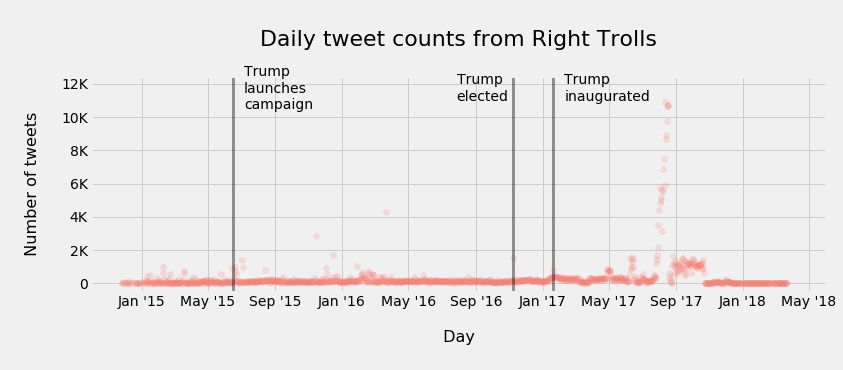

In [17]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8, bottom=0.2, left=0.1)

# Converter to convert date strings to datetime objects
conv = np.vectorize(mdates.strpdate2num('%Y-%m-%d'))

data = tweets_by_date_bots

# plt.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='salmon')
ax.set_title('\n Daily tweet counts from Right Trolls \n',
             size=22)
ax.set_xlabel('\n Day \n', size=16)
ax.set_ylabel('\n Number of tweets \n', size=16)
ax.set_ylim(-500, 12500)
ax.set_yticks(range(0, 14000, 2000))
ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])
ax.set_xlim(conv('2014-10-01'), conv('2018-06-01'))

month_yr_fmt = mdates.DateFormatter("%b '%y")
ax.xaxis.set_major_formatter(month_yr_fmt)


plt.axvline(conv('2015-06-16'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2015-06-16') + 20, 10500, 'Trump\nlaunches\ncampaign')
plt.axvline(conv('2016-11-8'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2016-07-8') + 20, 11000, 'Trump\nelected')
plt.axvline(conv('2017-01-20'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2017-01-20') + 20, 11000, 'Trump\ninaugurated')
plt.savefig('../../results/img/00_tweets_by_date_bots.png')

In [13]:
tweets_by_date_verified = pd.read_csv('../../data/06_reporting/tweets_by_date_verified.csv', parse_dates=[0])
print(tweets_by_date_verified.shape)
tweets_by_date_verified.head()

(1110, 2)


,publish_date,num_of_tweets
0,2014-12-18,26
1,2014-12-19,18
2,2014-12-20,7
3,2014-12-21,10
4,2014-12-22,12


c:\users\joey\learn-env2\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The strpdate2num class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use time.strptime or dateutil.parser.parse or datestr2num instead.
  import sys


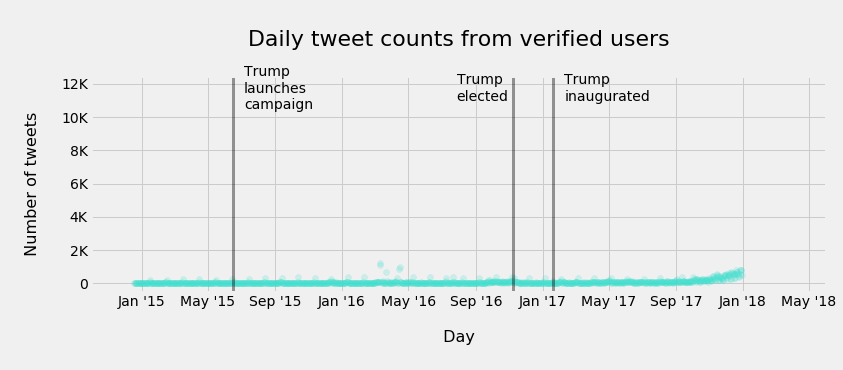

In [16]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8, bottom=0.2, left=0.1)

# Converter to convert date strings to datetime objects
conv = np.vectorize(mdates.strpdate2num('%Y-%m-%d'))

data = tweets_by_date_verified

# plt.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='turquoise')
ax.set_title('\n Daily tweet counts from verified users \n',
             size=22)
ax.set_xlabel('\n Day \n', size=16)
ax.set_ylabel('\n Number of tweets \n', size=16)
ax.set_ylim(-500, 12500)
ax.set_yticks(range(0, 14000, 2000))
ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])
ax.set_xlim(conv('2014-10-01'), conv('2018-06-01'))

month_yr_fmt = mdates.DateFormatter("%b '%y")
ax.xaxis.set_major_formatter(month_yr_fmt)


plt.axvline(conv('2015-06-16'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2015-06-16') + 20, 10500, 'Trump\nlaunches\ncampaign')
plt.axvline(conv('2016-11-8'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2016-07-8') + 20, 11000, 'Trump\nelected')
plt.axvline(conv('2017-01-20'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2017-01-20') + 20, 11000, 'Trump\ninaugurated')
plt.savefig('../../results/img/01_tweets_by_date_verified.png')

#### Explore top hashtags

In [45]:
generate_hashtags_counts(right_trolls, new_filepath='../../data/06_reporting/hashtags_counts_bots.csv')

Processing all hashtags into one list...
...done.
List of all hashtags has length 262827
  Saved ../../data/06_reporting/hashtags_counts_bots.csv with shape (19232, 2)


In [139]:
top_hashtags_bots = pd.read_csv('../../data/06_reporting/hashtags_counts_bots.csv')
print(top_hashtags_bots.shape)
top_hashtags_bots.head(50)

(19232, 2)


,hashtag,counts
0,#top,6237
1,#MAGA,5426
2,#mar,4666
3,#IslamKills,3841
4,#topl,3820
5,#tcot,3355
6,#PJNET,3328
7,#amb,2749
8,#DemnDebate,2278
9,#th,2122


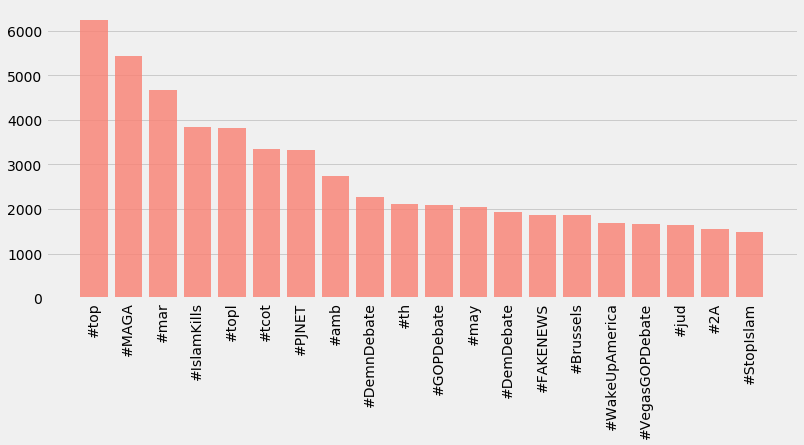

In [141]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
# plt.gcf().subplots_adjust(top=0.85, bottom=0.15)
# plt.gca().invert_yaxis()

data = top_hashtags_bots.set_index('hashtag').head(20)

ax.bar(data.index, data.counts, color='salmon', alpha=0.8)
ax.grid(b=False, axis='x')
ax.set_xticklabels(data.index, rotation=90);
# ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
# ax.set_title('\n Daily tweet counts from Right Trolls \n',
#              size=22)
# ax.set_xlabel('\n Day \n', size=16)
# ax.set_ylabel('\n Number of tweets \n', size=16)
# ax.set_ylim(-500, 12500)
# ax.set_yticks(range(0, 14000, 2000))
# ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])

#### See what's hogging memory

In [6]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_train', 233568058),
 ('X_test', 17621464),
 ('y_train', 576016),
 ('y_test', 43472),
 ('AdaBoostClassifier', 536),
 ('CountVectorizer', 536),
 ('Counter', 536),
 ('DecisionTreeClassifier', 536),
 ('FreqDist', 536),
 ('KNeighborsClassifier', 536),
 ('LogisticRegression', 536),
 ('MultinomialNB', 536),
 ('Pipeline', 536),
 ('RandomForestClassifier', 536),
 ('StandardScaler', 536),
 ('TfidfVectorizer', 536),
 ('WordNetLemmatizer', 536),
 ('XGBClassifier', 536),
 ('accuracy_score', 72),
 ('confusion_matrix', 72),
 ('f1_score', 72),
 ('generate_combined_features_X', 72),
 ('generate_emoji_vector_for_X', 72),
 ('generate_hashtag_vector_for_X', 72),
 ('generate_hashtags_counts', 72),
 ('generate_numeric_vector_for_X', 72),
 ('generate_tweets_by_date', 72),
 ('generate_unbalanced_X_and_y', 72),
 ('generate_word_vector_for_X', 72),
 ('recall_score', 72),
 ('train_test_split', 72),
 ('validate_train_test_split', 72),
 ('word_tokenize', 72),
 ('mdates', 44),
 ('np', 44),
 ('p', 44),
 ('pd', 

In [30]:
del(test_df)
del(train)
del(test)
del(validate)
del(X_train)
del(X_test)
del(X_valid)

In [24]:
for obj in [, train, test, validate, X_train, X_test, X_valid]:
    del(df)

#### Look at different author-level characteristics?

In [23]:
right_trolls.author.nunique()

622

# Old code

#### Hashtags used to pull verified tweets using `Twint`

Query the top 50 hashtags that are most frequently used by trolls (more than 1000 mentions)

In [17]:
top_hashtags_bots[top_hashtags_bots.counts > 1000]

,hashtag,counts
0,#MAGA,6817
1,#top,6580
2,#mar,4691
3,#PJNET,4665
4,#FAKENEWS,4306
5,#tcot,4042
6,#IslamKills,3854
7,#topl,3832
8,#amb,2749
9,#DemnDebate,2397


Also query the next 15 hashtags that seem like phrases

In [37]:
top_hashtags_bots[top_hashtags_bots.hashtag.str.contains('[A-Z]+', regex=True)][23:].head(30)

,hashtag,counts
57,#StopTheGOP,934
63,#Obama,878
64,#CruzCrew,870
75,#ISIS,819
78,#OscarHasNoColor,805
82,#BlackLivesMatter,797
97,#POTUS,674
98,#FakeNews,655
99,#DrainTheSwamp,653
102,#FeelTheBern,620


#### Tweepy testing - OLD

In [80]:
with open('../../conf/local/twitter_credentials.json', 'rb') as f:
    data = f.read()
    twitter_creds = json.loads(data)
api_key = twitter_creds['API_KEY']
api_secret_key = twitter_creds['API_SECRET_KEY']

In [95]:
# Replace the API_KEY and API_SECRET with your application's key and secret.
auth = tweepy.AppAuthHandler(api_key, api_secret_key)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

searchQuery = '#MAGA -filter:retweets filter:verified'  # this is what we're searching for
maxTweets = 1000# 10000000 # Some arbitrary large number
tweetsPerQry = 100  # this is the max the API permits
fName = '../../data/01_raw/tweets_test.csv' # We'll store the tweets in a text file.


# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry)
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 660 tweets
No more tweets found
Downloaded 660 tweets, Saved to ../../data/01_raw/tweets_test.csv
